# <b>1 <span style='color:#0386f7de'>|</span> Stroke Prediction</b>

# <b>2 <span style='color:#0386f7de'>|</span> Importing libraries </b>

In [ ]:
# packages

# standard
import numpy as np
import pandas as pd
import time

# plot
import matplotlib.pyplot as plt
import seaborn as sns

# statistics tools
from statsmodels.graphics.mosaicplot import mosaic

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from keras import layers
from keras.layers import Input, Dense,BatchNormalization,Dropout
from keras.models import Sequential
from tensorflow.keras import layers
%pip install livelossplot
from livelossplot import PlotLossesKeras

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


# <b>3 <span style='color:#0386f7de'>|</span> Reading the dataset </b>

In [ ]:
# load data
df = pd.read_csv('https://raw.githubusercontent.com/FrancescaFati/SmartHospitals2024/main/healthcare-dataset-stroke-data.csv')

In [ ]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [ ]:
df = df.dropna()
df.shape

(4909, 12)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


# Step 2: Preprocess the dataset
# Identify categorical and numerical columns
categorical_cols = [cname for cname in df.columns if df[cname].dtype == "object"]
numerical_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]

In [ ]:
categorical_cols

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [ ]:
numerical_cols

['id',
 'age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'bmi',
 'stroke']

In [ ]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Convert categorical variables to dummy variables
])


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ])

In [ ]:
# Remove the target variable and separate it
X = df.drop('stroke', axis=1)
y = df['stroke']

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


In [ ]:
# Step 4: Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [ ]:
def draw_neural_net(model, left =.1, right=.9, bottom=.1, top=.9):
    '''
    Draw a neural network cartoon using matplotilb.

    :param ax: matplotlib.axes.Axes, the axes on which to plot the cartoon
    :param left: float, the center of the leftmost node(s) will be placed here
    :param right: float, the center of the rightmost node(s) will be placed here
    :param bottom: float, the center of the bottommost node(s) will be placed here
    :param top: float, the center of the topmost node(s) will be placed here
    :param layer_sizes: list of int, list containing the number of nodes in each layer
    '''
    layer_sizes = [model.input_shape[-1]]
    for layer in model.layers:
        # Check if layer is a Dense layer (ignoring input and output layers for simplicity)
        if isinstance(layer, tf.keras.layers.Dense):
            layer_sizes.append(layer.units)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    fig = plt.figure(figsize=(20,10))
    ax = fig.gca()
    ax.axis('off')
    ax.set_aspect('equal')
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
            # Annotation for the layer number
            if m == layer_size - 1:
                plt.text(n*h_spacing + left, layer_top - m*v_spacing - v_spacing*3, f'{layer_size} N',
                         ha='center', va='center')
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k',linewidth=0.25)
                ax.add_artist(line)
                plt.title("Rete Neurale")
    plt.show()

def reinitialize(model):
    for l in model.layers:
        if hasattr(l,"kernel_initializer"):
            l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
        if hasattr(l,"bias_initializer"):
            l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
        if hasattr(l,"recurrent_initializer"):
            l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))

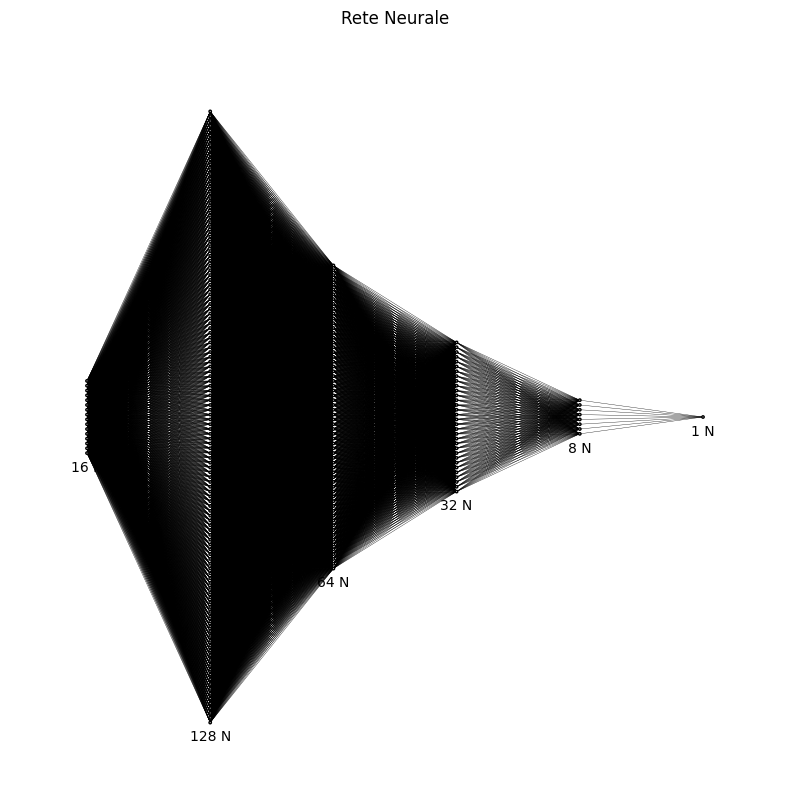

In [ ]:
draw_neural_net(model)

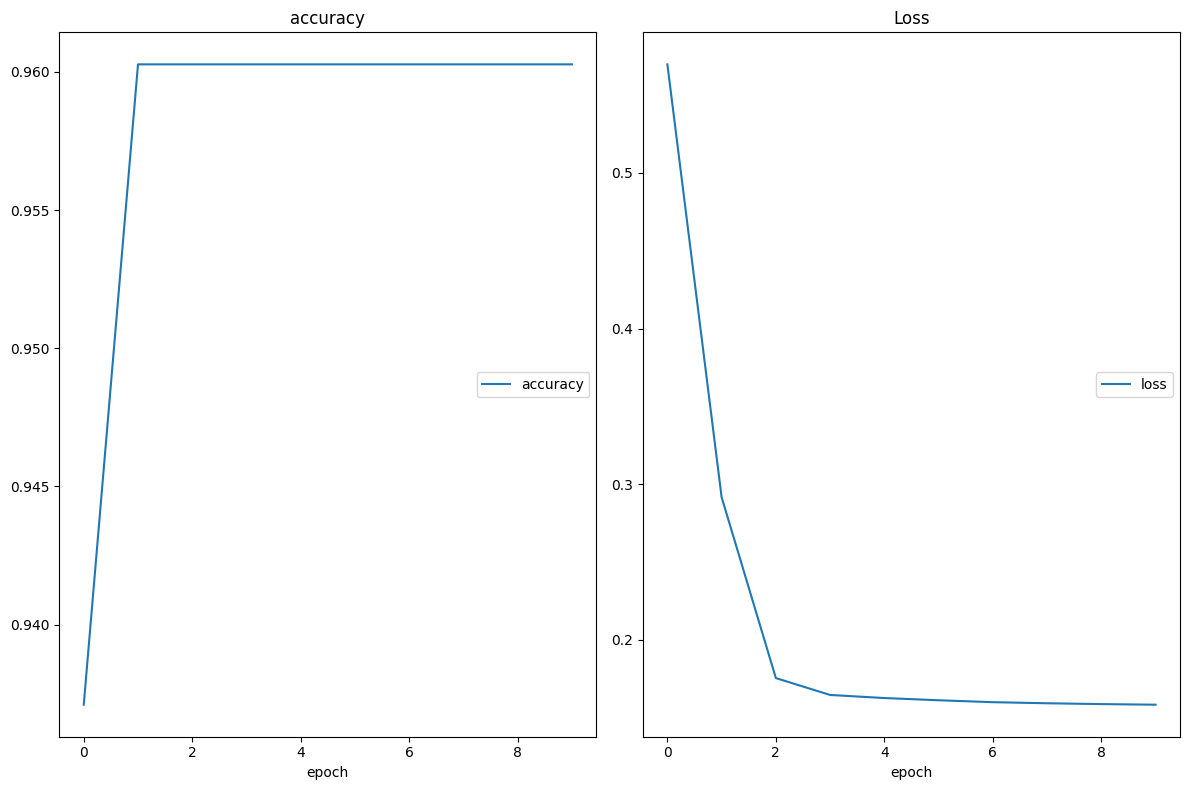

accuracy
	accuracy         	 (min:    0.937, max:    0.960, cur:    0.960)
Loss
	loss             	 (min:    0.158, max:    0.570, cur:    0.158)


In [ ]:
###################################################################
LEARNING_RATE = 1e-4
BATCH_SIZE    = 32          # TODO: Change Hyperparameters
EPOCHE        = 10
###################################################################

# Step 5: Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics='accuracy'
)

# Step 6: Train the model
history=model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHE,
    callbacks=[PlotLossesKeras()],
    verbose=0
)

In [ ]:
# Step 7: Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

31/31 [==============================] - 0s 4ms/step - loss: 0.2048 - accuracy: 0.9460
Test accuracy: 0.9460285305976868, Test loss: 0.2048404961824417


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)  # Threshold probabilities to get binary labels

cm = confusion_matrix(y_test, predictions)


31/31 [==============================] - 0s 1ms/step


In [ ]:
print(cm)

[[929   0]
 [ 53   0]]


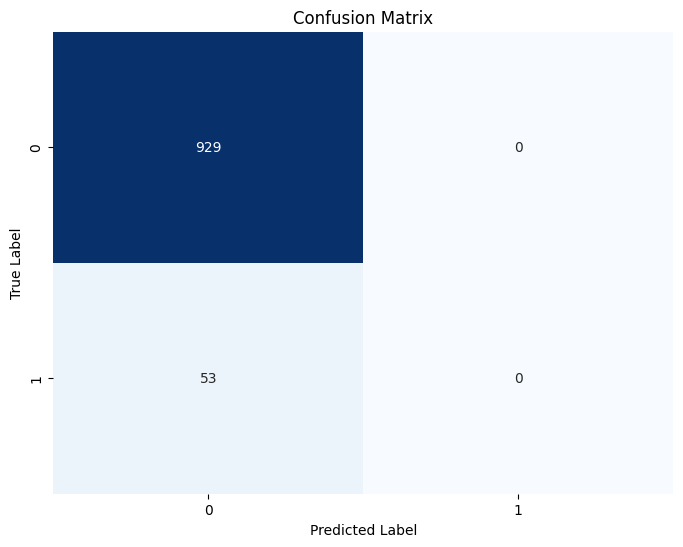

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assume cm is already computed
cm = np.array([[929, 0], [53, 0]])  # Example confusion matrix

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)  # 'd' for integer formatting
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()
